# Adding multiple chips to wafer

In [50]:
import sys
main_folder_path = r"C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid"
sys.path.append(main_folder_path)

In [51]:

import os
import phidl.geometry as pg
from phidl import Device, quickplot as qp
import numpy as np
from utilities import *

# Create a blank wafer layout
wafer = Device("Dravid_wafer_optical")

# Add wafer outline (2-inch wafer = 5.08 cm = 50,800 um diameter)
wafer_radius = 45000   # um
wafer << pg.circle(radius=wafer_radius, layer=0)


DeviceReference (parent Device "circle", ports [], origin (0, 0), rotation 0, x_reflection False)

# Coherence Junctions Triad_half

In [52]:
juncs_triad_upper_half_x_offset = 0 
juncs_triad_lower_half_y_offset = 0

## Multimode Qubit

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Importing designs_dxf/DRAVIDQUBITS_OPT-A.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-B.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-C.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-D.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-E.gds


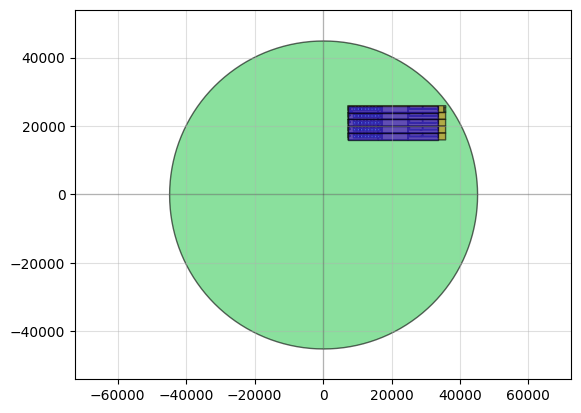

In [55]:

# Qubits 
# Define path to DXF file to import
qubit_chip_width = 2000 # um 
# path = r"C:\Users\eeshg\Documents\multimode_sims\Design\coupler"  # <-- UPDATE THIS
path = 'designs_dxf/'
with open("multimode/chip_names_qubit.txt", "r") as f:
    chip_names_read = [os.path.basename(line.strip()) for line in f.readlines()]
upper_dxf_files = chip_names_read[:5]
lower_dxf_files = chip_names_read[-5:]


# x pos and y pos offsets for the qubit chips
xpos_offset = -7000 - 20000 + 1251.5 -1.5  + juncs_triad_upper_half_x_offset # um
ypos_offset = 500 + 4500 -1.5+2500  + juncs_triad_lower_half_y_offset # um

# Import the GDS structure
for idx, file in enumerate(upper_dxf_files):
    wafer, qubit_obj = add_dxf_chip_to_wafer(wafer, file, path, qubit_chip_width, idx, x_offset=xpos_offset, y_offset=ypos_offset, add_bool=False)
    # qubit_obj.rotate(0)  # Rotate the qubit chip by 90 degrees
    wafer, qubit_negative, qubit_bbox = add_qubit_bbox_and_negative_mask(wafer, qubit_obj, qubit_chip_width, idx, xpos_offset=xpos_offset, ypos_offset=ypos_offset)
    qubit_negative.rotate(-90)  # Rotate the qubit chip by 90 degrees
    qubit_bbox.rotate(-90)  # Rotate the bounding box by 90 degrees
# Save the resulting wafer layout
wafer.write_gds("wafer_with_imported_dxf.gds")

# Quick preview (optional)
qp(wafer)



## Coherence Transmons

In [56]:
folder_lab_designs = "lab_designs/"
coh_trans_files = [
    folder_lab_designs + "SiQbv2_wide_JJ_EEEEEEESH_jc0.1_offset0.0.gds",
    folder_lab_designs + "SiQbv2_wide_JJ_EEEEEEESH_jc0.2_offset0.0.gds",
    folder_lab_designs + "SiQbv2_wide_JJ_EEEEEEESH_jc0.3_offset0.0.gds"
]

In [57]:
def add_coherence_qubits(
    wafer_device,
    x_offset,
    y_offset,
    qubit_gds=None,
    bbox_size=7000,
    spacing=None,
    num_qubits=1
):
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([0] * num_qubits)
    blank_y_arr = np.array([0] * num_qubits)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    # blank_x_arr = #[blank_x_arr[i] + (i) * spacing for i in range(num_qubits)]
    blank_y_arr = [blank_y_arr[i] + (i) * spacing for i in range(num_qubits)]

    for i in range(num_qubits):
        qubit_raw = pg.import_gds(qubit_gds)
        qubit_pos = pg.copy_layer(qubit_raw, layer=5, new_layer=5)
        qubit_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << qubit_pos.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << qubit_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = qubit_bbox.xmax
        xmin = qubit_bbox.xmin
        ymax = qubit_bbox.ymax
        ymin = qubit_bbox.ymin

        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))


In [58]:
x_offset = 12000 + juncs_triad_upper_half_x_offset
y_offset = 10000 - 5000 + juncs_triad_lower_half_y_offset
num_copies = 2
for idx, file in enumerate(coh_trans_files):
    add_coherence_qubits(wafer, x_offset=x_offset + idx*7000,
                          y_offset=y_offset, 
                          num_qubits=num_copies, qubit_gds=file)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


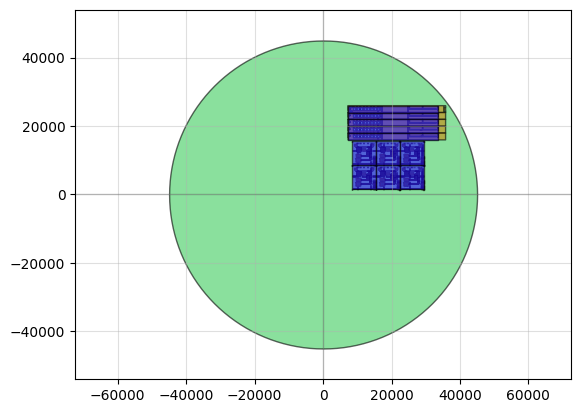

In [59]:
qp(wafer)

## Ion Milling Mask

In [60]:
def add_ion_milling_mask(
    wafer_device,
    x_offset,
    y_offset,
    qubit_gds=None,
    bbox_size=7000,
    spacing=None,
    num_qubits=1
):
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([0] * num_qubits)
    blank_y_arr = np.array([0] * num_qubits)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    # blank_x_arr = #[blank_x_arr[i] + (i) * spacing for i in range(num_qubits)]
    blank_y_arr = [blank_y_arr[i] + (i) * spacing for i in range(num_qubits)]

    for i in range(num_qubits):
        qubit_raw = pg.import_gds(qubit_gds)
        qubit_pos = pg.copy_layer(qubit_raw, layer=1, new_layer=5).move((-bbox_size / 2, -bbox_size / 2))
        qubit_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << qubit_pos.move((blank_x_arr[i] + bbox_size / 2 + 50, blank_y_arr[i] + bbox_size / 2 + 100))
        wafer_device << qubit_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = qubit_bbox.xmax
        xmin = qubit_bbox.xmin
        ymax = qubit_bbox.ymax
        ymin = qubit_bbox.ymin

        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))


In [61]:
x_offset = 12000 + juncs_triad_upper_half_x_offset + 7000*3 
y_offset = 10000 - 5000 #+ 3700
num_copies = 1
ion_milling_file = folder_lab_designs + "ion_mill_mask_v5.gds"
# for idx, file in enumerate(coh_trans_files):
add_ion_milling_mask(wafer, x_offset=x_offset,
                        y_offset=y_offset,
                        num_qubits=1, qubit_gds=ion_milling_file)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


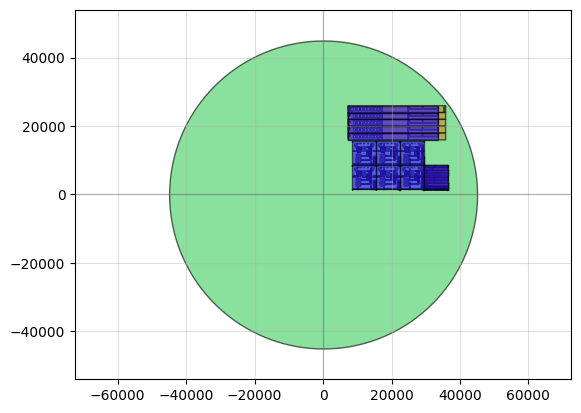

In [62]:
qp(wafer)

## Multimode Coupler Test Structures

In [63]:
#Make the following code into a function : add bounding boxes and return negative mas 
# it should take arguments wafer, coupler_chip_obj, coupler_width, idx
# and return the wafer with the negative mask added
# only the coupler text_bbox remain (no coupler chip)
import phidl.geometry as pg

def add_test_structure_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset, ypos_offset):
    coupler_length = 48500
    test_structure_length = 4500 + 2000

    xpos = xpos_offset + (idx * coupler_width)
    ypos = ypos_offset

    # (Optional) draw the visual bounding boxes as before
    # coupler_bbox = pg.rectangle(size=(coupler_width, coupler_length), layer=13)
    # wafer << coupler_bbox.move((xpos - 100, ypos - 100))

    test_structure_bbox_vis = pg.rectangle(size=(coupler_width, test_structure_length), layer=13)
    wafer << test_structure_bbox_vis.move((xpos - 100, ypos + coupler_length - 100))

    # ---- KEY CHANGE ----
    # Build a *test-structures-only* window in the coupler_chip_obj's local coords,
    # then subtract the coupler geometry from that window.
    test_structure_window = pg.rectangle(size=(coupler_width, test_structure_length), layer=14)
    test_structure_window.move((-100, coupler_length - 100))  # place directly above the coupler region

    # A \ B keeps ONLY the top test-structure band and removes whatever the coupler object occupies there
    test_structures_negative = pg.boolean(
        A=test_structure_window,
        B=coupler_chip_obj,
        operation='not',     # A minus B (no reintroduction of the bottom chip)
        layer=5,
        precision=1e-3
    )

    wafer << test_structures_negative.move((xpos, ypos))
    return wafer


Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-C.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


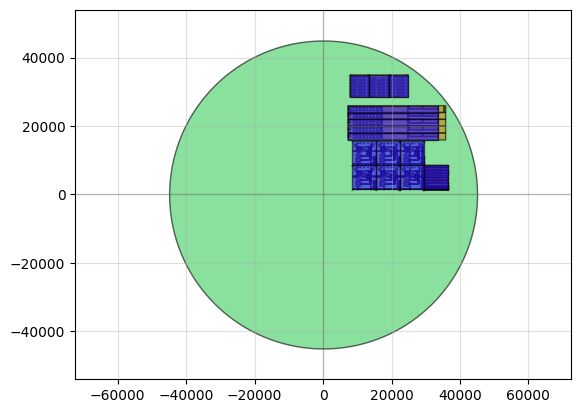

In [64]:
with open("multimode/chip_names_coupler.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
coupler_files = chip_names_read[:3]
coupler_width = 5650

coupler_test_xoffset = 8000 + juncs_triad_upper_half_x_offset
coupler_test_yoffset = -20000 + juncs_triad_lower_half_y_offset
# Import the GDS structure
for idx, file in enumerate(coupler_files):
    wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=0, y_offset=0,
                                                    add_bool = False)

    wafer = add_test_structure_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=coupler_test_xoffset, ypos_offset=coupler_test_yoffset)
qp(wafer)

In [65]:
wafer.write_gds("wafer_with_imported_dxf.gds")

'wafer_with_imported_dxf.gds'

## Bottom half of triad 


In [36]:
coh_juncs_bottom_half_x_offset = 0
coh_juncs_bottom_half_y_offset = -34000

In [37]:
# draw multimode qubit, coherence qubits and coupler test structures but on lower half 

# Multimode Qubits (lower half)
qubit_chip_width = 2000
xpos_offset_down = -7000 - 20000 + 1251.5 - 1.5 - 1500+44100  - coh_juncs_bottom_half_x_offset # same as above
ypos_offset_down = 500 + 4500 -1.5+2500   # lower half y offset

for idx, file in enumerate(lower_dxf_files):
    wafer, qubit_obj = add_dxf_chip_to_wafer(wafer, file, path, qubit_chip_width, idx, x_offset=xpos_offset_down, y_offset=ypos_offset_down, add_bool=False)
    wafer, qubit_negative, qubit_bbox = add_qubit_bbox_and_negative_mask(wafer, qubit_obj, qubit_chip_width, idx, xpos_offset=xpos_offset_down, ypos_offset=ypos_offset_down)
    qubit_negative.rotate(-90)
    qubit_bbox.rotate(-90)

# Coherence Qubits (lower half)
x_offset_down = 12000
y_offset_down = 5000 + coh_juncs_bottom_half_y_offset + 17000
num_copies = 2
for idx, file in enumerate(coh_trans_files):
    add_coherence_qubits(wafer, x_offset=x_offset_down + idx*7000,
                         y_offset=y_offset_down,
                         num_qubits=num_copies, qubit_gds=file)

#ion milling mask
x_offset = 12000 + juncs_triad_upper_half_x_offset + 7000*3 
y_offset = 5000 + coh_juncs_bottom_half_y_offset + 17000
num_copies = 1
ion_milling_file = folder_lab_designs + "ion_mill_mask_v5.gds"
add_ion_milling_mask(wafer, x_offset=x_offset,
                        y_offset=y_offset,
                        num_qubits=1, qubit_gds=ion_milling_file)

# Coupler Test Structures (lower half)
coupler_test_xoffset_down = 8000
coupler_test_yoffset_down = -20000 + coh_juncs_bottom_half_y_offset - 28500
for idx, file in enumerate(coupler_files):
    wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=0, y_offset=0, add_bool=False)
    wafer = add_test_structure_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=coupler_test_xoffset_down, ypos_offset=coupler_test_yoffset_down)

Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVIDQUBITS_OPT-F.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVIDQUBITS_OPT-G.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVIDQUBITS_OPT-H.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVIDQUBITS_OPT-I.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVIDQUBITS_OPT-J.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-C.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


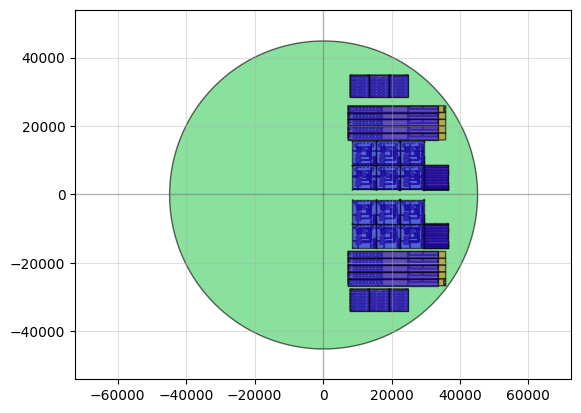

In [38]:
qp(wafer)

# Tripoles and Resonators Triad

## Tripoles

In [39]:
resonator_triad_x_offset = 32000 - 500 - 1000
resonator_triad_y_offset = -4000

Importing lab_designs/eesh_tripole_9_2_25_union_with_dicing.gds
Importing lab_designs/eesh_tripole_9_2_25_union_with_dicing.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


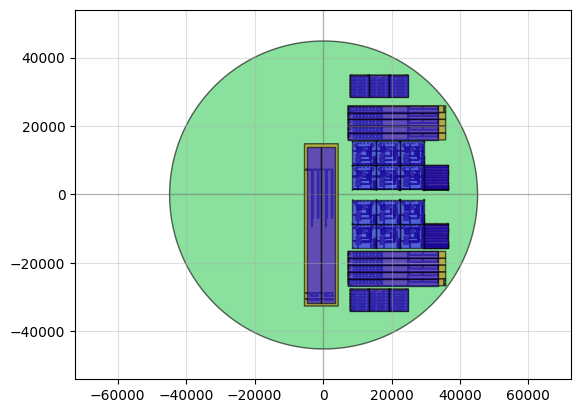

In [40]:
tripole_x_offset = resonator_triad_x_offset
tripole_y_offset = resonator_triad_y_offset
matt_chip_name = folder_lab_designs + 'eesh_tripole_9_2_25_union_with_dicing.dxf'
# optical layer
add_dxf_chip_to_wafer(wafer, matt_chip_name, path, layer_in=15,
                          layer_out=5, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
# dicing layer
add_dxf_chip_to_wafer(wafer, matt_chip_name, path, layer_in=13,
                          layer_out=13, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
qp(wafer)

Importing lab_designs/eesh_tripole_9_2_25_union_with_dicing.gds
Importing lab_designs/eesh_tripole_9_2_25_union_with_dicing.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


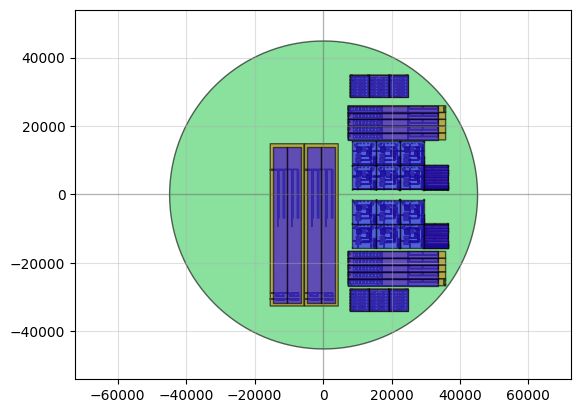

In [41]:
tripole_x_offset = resonator_triad_x_offset - 10000
tripole_y_offset = resonator_triad_y_offset
matt_chip_name = folder_lab_designs + 'eesh_tripole_9_2_25_union_with_dicing.dxf'
# optical layer
add_dxf_chip_to_wafer(wafer, matt_chip_name, path, layer_in=15,
                          layer_out=5, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
# dicing layer
add_dxf_chip_to_wafer(wafer, matt_chip_name, path, layer_in=13,
                          layer_out=13, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
qp(wafer)

## Resonators

In [42]:
def add_coherence_resonators(
    wafer_device,
    x_offset,
    y_offset,
    num_resonators,
    resonator_gds=None,
    bbox_size=7000,
    spacing=None
):
    blank_params = {'size': 7000}
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([-31000] * num_resonators)
    blank_y_arr = np.array([27000] * num_resonators)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_resonators)]

    for i in range(num_resonators):
        # coh_res_raw = pg.import_gds(resonator_gds)
        # coh_res_pos = pg.copy_layer(coh_res_raw, layer=5, new_layer=5)
        coh_res_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        #wafer_device << coh_res_pos.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << coh_res_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = coh_res_bbox.xmax
        xmin = coh_res_bbox.xmin
        ymax = coh_res_bbox.ymax
        ymin = coh_res_bbox.ymin

        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))



In [43]:
add_coherence_resonators(wafer_device=wafer,
                         x_offset=resonator_triad_x_offset-12000,
                            y_offset=resonator_triad_y_offset-4000,
                            num_resonators=3,
                            resonator_gds=folder_lab_designs + "center_feedline_resonator_holes1_mod.gds",
                            bbox_size=7000,)

add_coherence_resonators(wafer_device=wafer,
                         x_offset=resonator_triad_x_offset-12000,
                            y_offset=resonator_triad_y_offset-4000-48000-8000,
                            num_resonators=3,
                            resonator_gds=folder_lab_designs + "center_feedline_resonator_holes1_mod.gds",
                            bbox_size=7000,)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


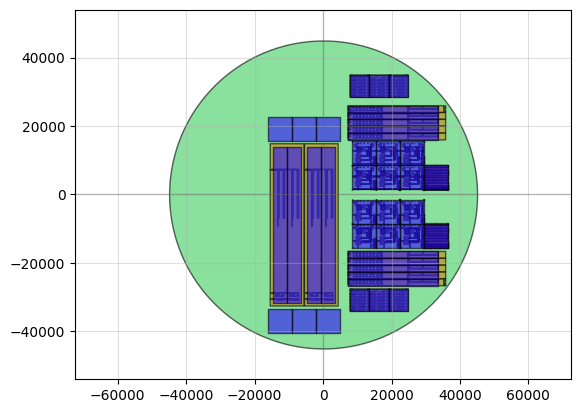

In [44]:
qp(wafer)

## Blanks

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


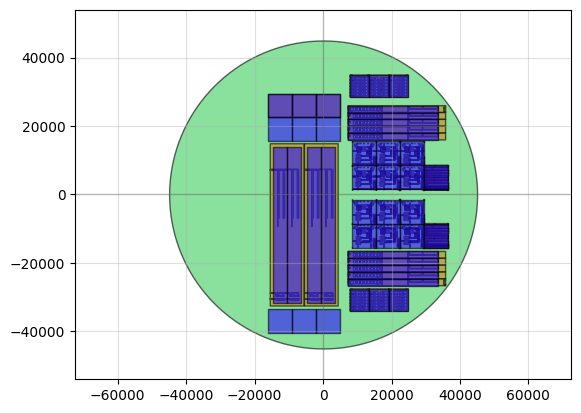

In [45]:
def add_blanks(
    wafer_device,
    x_offset,
    y_offset,
    num_blanks,
    bbox_size=7000,
    spacing=None
):
    if spacing is None:
        spacing = bbox_size

    blank_x_arr = np.array([-31000] * num_blanks)
    blank_y_arr = np.array([27000] * num_blanks)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_blanks)]

    for i in range(num_blanks):
        rect_layer5 = pg.rectangle(size=(bbox_size, bbox_size), layer=5).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        rect_layer13 = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        wafer_device << rect_layer5.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << rect_layer13.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))

add_blanks(wafer_device=wafer,
           x_offset=resonator_triad_x_offset-12000,
           y_offset=resonator_triad_y_offset+3000,
           num_blanks=3,
           bbox_size=7000,
           spacing=0)
qp(wafer)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


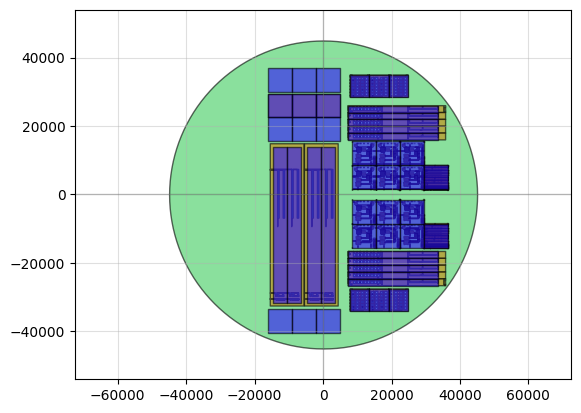

In [46]:
def add_blanks_metal(
    wafer_device,
    x_offset,
    y_offset,
    num_blanks,
    bbox_size=7000,
    spacing=None
):
    if spacing is None:
        spacing = bbox_size

    blank_x_arr = np.array([-31000] * num_blanks)
    blank_y_arr = np.array([27000] * num_blanks)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_blanks)]

    for i in range(num_blanks):
        # rect_layer5 = pg.rectangle(size=(bbox_size, bbox_size), layer=5).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        rect_layer13 = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        # wafer_device << rect_layer5.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << rect_layer13.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))

add_blanks_metal(wafer_device=wafer,
           x_offset=resonator_triad_x_offset-12000,
           y_offset=resonator_triad_y_offset+3000 + 7500,
           num_blanks=3,
           bbox_size=7000,
           spacing=0)
qp(wafer)


# Multimode Coupler Triad

In [47]:
#Make the following code into a function : add bounding boxes and return negative mas 
# it should take arguments wafer, coupler_chip_obj, coupler_width, idx
# and return the wafer with the negative mask added
def add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset,
                                       ypos_offset):
    coupler_length = 48500
    test_structure_length = 4500 +2000

    xpos = xpos_offset + (idx * coupler_width)
    ypos = ypos_offset

    coupler_bbox = pg.rectangle(size=(coupler_width, coupler_length), layer=13)
    wafer << coupler_bbox.move((xpos - 100, ypos - 100))

    test_structure_bbox = pg.rectangle(size=(coupler_width, test_structure_length), layer=13)
    wafer << test_structure_bbox.move((xpos - 100, ypos + coupler_length - 100))

    coupler_chip_bbox = pg.rectangle(size=(coupler_width, coupler_length + test_structure_length), layer=14)
    coupler_chip_bbox.move((-100, -100))

    coupler_negative = pg.boolean(A=coupler_chip_bbox, B=coupler_chip_obj, operation='xor', layer=5)
    wafer << coupler_negative.move((xpos, ypos))

    return wafer

Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-C.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


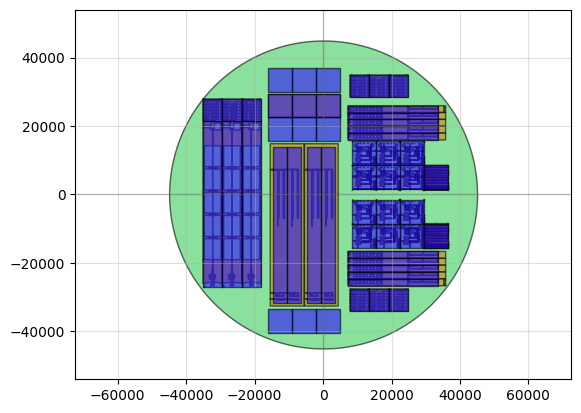

In [48]:
with open("multimode/chip_names_coupler.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
coupler_files = chip_names_read[:3]
coupler_width = 5650
# Import the GDS structure
for idx, file in enumerate(coupler_files):
    wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=-35000, y_offset=-27000,
                                                    add_bool = False)

    wafer = add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=-35000, ypos_offset=-27000)
qp(wafer)

# Saving

In [49]:
wafer.write_gds("JadduOptical_dicing.gds")

'JadduOptical_dicing.gds'